In [41]:
#Import necessary libs
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns #For heatmap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing

import catboost as cb
%matplotlib inline

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

In [42]:
def load_all_data():
    train_a = pd.read_parquet('data/A/train_targets.parquet')
    train_b = pd.read_parquet('data/B/train_targets.parquet')
    train_c = pd.read_parquet('data/C/train_targets.parquet')

    # Estimated training data for each location
    X_train_estimated_a = pd.read_parquet('data/A/X_train_estimated.parquet')
    X_train_estimated_b = pd.read_parquet('data/B/X_train_estimated.parquet')
    X_train_estimated_c = pd.read_parquet('data/C/X_train_estimated.parquet')

    # Observed training data for each location
    X_train_observed_b = pd.read_parquet('data/B/X_train_observed.parquet')
    X_train_observed_a = pd.read_parquet('data/A/X_train_observed.parquet')
    X_train_observed_c = pd.read_parquet('data/C/X_train_observed.parquet')

    # Estimated test data for each location
    X_test_estimated_b = pd.read_parquet('data/B/X_test_estimated.parquet')
    X_test_estimated_a = pd.read_parquet('data/A/X_test_estimated.parquet')
    X_test_estimated_c = pd.read_parquet('data/C/X_test_estimated.parquet')

    Y_train = {
        'a': train_a, 
        'b':train_b, 
        'c':train_c
    }
    X_train_estimated = {
        'a':X_train_estimated_a,
        'b':X_train_estimated_b,
        'c':X_train_estimated_c
    }
    X_train_observed = {
        'a':X_train_observed_a,
        'b':X_train_observed_b,
        'c':X_train_observed_c
    }
    X_test_estimated = {
        'a':X_test_estimated_a,
        'b':X_test_estimated_b,
        'c':X_test_estimated_c
    }
    return  X_train_observed, X_train_estimated, X_test_estimated, Y_train


def make_categorical(data, feature_list):
    for feature in feature_list:
        data[feature] = data[feature].astype('category')


def to_hourly(df):
    df['date_forecast']
    df.set_index('date_forecast', inplace=True)
    df = df.resample('H').mean()
    df.reset_index(inplace=True)
    return df

def add_type(data, type):
    data['type'] = [type] * len(data)
    # data['type'] = data['type'].astype('category')

def combine_obs_est(obs, est):
    """
    Concatinates the estimated and observed data. 
    Removes data_calc from est.
    """

    # est = est.drop('date_calc', axis = 1)
    X_train = pd.concat([obs, est])
    X_train = X_train.reset_index(drop=True)
    
    return X_train

def add_location(data, location):
    """
    Adds a categorical feature "location" equal to the input string location.
    """
    loc = [location] * len(data)
    data['location'] = loc
    # data['location'] = data['location'].astype('category')


def match_X_Y(X,Y):
    """ 
    date_forecast and time must be unique!
    Matches the timestamps of X to the timestamps of Y. 
    Makes sure that the length of X and Y are equal.
    """
    Y = Y.dropna()
    X = X.rename(columns={'date_forecast': 'time'})
    merge_df = Y.merge(X, on="time", how='inner')
    Y = merge_df['pv_measurement']
    X = merge_df.drop(columns = ['pv_measurement'])
    return X,Y

def select_features(features,X_train_observed, X_train_estimated, X_test_estimated):
    """ 
    Reduces dim by selecting only features from "features"
    This will remove "date_calc" from est.
    """
    for loc in ['a','b','c']:
       X_train_observed[loc] = X_train_observed[loc][features]
       X_train_estimated[loc] = X_train_estimated[loc][features]
       X_test_estimated[loc] = X_test_estimated[loc][features]


def fix_cat_features(categorical_list, X_train_observed, X_train_estimated, X_test_estimated, location = False, type = False):
    """
    Takes in dicts as given by load_all_data().
    Makes all categorical features actually categorical.
    Adds location or type of you want.
    """
    for loc in ['a','b','c']:
        if location:
            add_location(X_train_observed[loc], loc)
            add_location(X_train_estimated[loc], loc)
            add_location(X_test_estimated[loc], loc)

        if type:
            add_type(X_train_observed[loc], 'obs')
            add_type(X_train_estimated[loc], 'est')
            add_type(X_test_estimated[loc], 'est')

        make_categorical(X_train_observed[loc],categorical_list)
        make_categorical(X_train_estimated[loc],categorical_list)
        make_categorical(X_test_estimated[loc],categorical_list)

def resample_to_hourly(X_train_observed, X_train_estimated, X_test_estimated):
    """ 
    Needs only non-categorical features as of now.
    """
    for loc in ['a','b','c']:
       X_train_observed[loc] = to_hourly(X_train_observed[loc])
       X_train_estimated[loc] = to_hourly(X_train_estimated[loc])
       X_test_estimated[loc] = to_hourly(X_test_estimated[loc])
    #    X_test_estimated[loc] = X_test_estimated[loc].dropna(subset = ['date_calc'], how = 'all')

def remove_nans(X_train_observed, X_train_estimated, X_test_estimated, feature):
    for loc in ['a','b','c']:
        cols = X_train_observed['a'].columns
        if feature in cols:
            X_train_observed[loc] = X_train_observed[loc].dropna(subset = [feature], how = 'all')
            X_train_estimated[loc] = X_train_estimated[loc].dropna(subset = [feature], how = 'all')
            X_test_estimated[loc] = X_test_estimated[loc].dropna(subset = [feature], how = 'all')
        else:
            print("Feature not in data frame.")

def ReLU(x):
    return x * (x > 0)

def remap(x):
    if x<0.5:
        return 0
    else:
        return 1



def pred_to_delivery(preds, filename):
    data = {'prediction':preds}
    sub = pd.DataFrame(data = data)
    sub = sub.reset_index()
    sub = sub.rename(columns={'index': 'id'})
    sub.to_csv(filename, index=False)

## Constants and lists

In [43]:
#Good
# selected_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
#                     'clear_sky_energy_1h:J', 'clear_sky_rad:W',
#                     'dew_point_2m:K',
#                     'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
#                     'effective_cloud_cover:p', 'is_in_shadow:idx',
#                     'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
#                     'pressure_100m:hPa', 'pressure_50m:hPa',
#                     'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
#                     'snow_water:kgm2', 'sun_azimuth:d',
#                     'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
#                     'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
#                     'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
#                     'location', 'type']

# selected_features = ['date_forecast', 'air_density_2m:kgm3',
#                     'clear_sky_energy_1h:J','absolute_humidity_2m:gm3',
#                     'dew_point_2m:K',
#                     'diffuse_rad:W', 'direct_rad:W',
#                     'effective_cloud_cover:p',
#                     'precip_5min:mm', 'is_in_shadow:idx',
#                     'pressure_100m:hPa',
#                     'relative_humidity_1000hPa:p',
#                     'sun_azimuth:d',
#                     'sun_elevation:d', 't_1000hPa:K',
#                     'visibility:m',
#                     'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
#                     ]
selected_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms']



made_features = ['location', 'is_in_shadow:idx']

drop_feature = 'diffuse_rad:W'

numeric_features = ['air_density_2m:kgm3',
                    'clear_sky_energy_1h:J',
                    'dew_point_2m:K',
                    'diffuse_rad:W', 'direct_rad:W',
                    'effective_cloud_cover:p',
                    'precip_5min:mm',
                    'pressure_100m:hPa',
                    'relative_humidity_1000hPa:p',
                    'sun_azimuth:d',
                    'sun_elevation:d', 't_1000hPa:K',
                    'visibility:m',
                    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms'
]

all_features = ['date_forecast', 'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
       'ceiling_height_agl:m', 'clear_sky_energy_1h:J', 'clear_sky_rad:W',
       'cloud_base_agl:m', 'dew_or_rime:idx', 'dew_point_2m:K',
       'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
       'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
       'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
       'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
       'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
       'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
       'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
       'snow_density:kgm3', 'snow_depth:cm', 'snow_drift:idx',
       'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
       'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
       'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
       'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
       'location', 'type']

#list of categorical:
categorical_list = [
    'dew_or_rime:idx',
    'is_day:idx',
    'is_in_shadow:idx',
    'precip_type_5min:idx',
    'snow_drift:idx'
]

# ToDo 

- Normalize features? 

- Feature importance, more systematically.

In [44]:
#Loading all data to dicts. 
X_train_observed, X_train_estimated, X_test_estimated, Y_train = load_all_data()



In [45]:
#There is an issue with the resampling and categorical features.
#Resampling first runs, but takes average over categorical which does not make sense.
#making categorical first does not run as i have not specified what to do with categorical.
#The fix for now is to not include any categorical except possibly location and type.


select_features(selected_features,X_train_observed, X_train_estimated, X_test_estimated)
resample_to_hourly(X_train_observed, X_train_estimated, X_test_estimated)
remove_nans(X_train_observed, X_train_estimated, X_test_estimated,drop_feature)
fix_cat_features([], X_train_observed, X_train_estimated, X_test_estimated, type=False, location=True)



## Training and test set preparation:

In [46]:
#Combine observed and estimated.
#We dont explicitly take distributional difference into account. 

X_train_a = combine_obs_est(X_train_observed['a'], X_train_estimated['a'])
X_train_b = combine_obs_est(X_train_observed['b'], X_train_estimated['b'])
X_train_c = combine_obs_est(X_train_observed['c'], X_train_estimated['c'])


X_a, y_a = match_X_Y(X_train_a, Y_train['a'])
X_b, y_b = match_X_Y(X_train_b, Y_train['b'])
X_c, y_c = match_X_Y(X_train_c, Y_train['c'])

local_test = True
if local_test:
    X_train_a , X_test_a, y_train_a, y_test_a = train_test_split(X_a, y_a, test_size=2160, shuffle=False)
    X_train_b , X_test_b, y_train_b, y_test_b = train_test_split(X_b, y_b, test_size=2160, shuffle=False)
    X_train_c , X_test_c, y_train_c, y_test_c = train_test_split(X_c, y_c, test_size=2160, shuffle=False)

    X_train = pd.concat([X_train_a,X_train_b, X_train_c])
    X_test = pd.concat([X_test_a,X_test_b,X_test_c])

    y_train = pd.concat([y_train_a, y_train_b, y_train_c])
    y_train = y_train.reset_index(drop=True)

    y_test = pd.concat([y_test_a, y_test_b, y_test_c])
    y_test = y_test.reset_index(drop=True)

else:

    y_train = pd.concat([y_a, y_b, y_c])
    y_train = y_train.reset_index(drop=True)

    #X Train
    X_train = pd.concat([X_a, X_b,X_c])
    #X Test
    X_test = pd.concat([X_test_estimated['a'], X_test_estimated['b'],X_test_estimated['c']])

if 'is_in_shadow:idx' in made_features:
    X_train['is_in_shadow:idx'] = X_train['is_in_shadow:idx'].map(remap)

    X_test['is_in_shadow:idx'] = X_test['is_in_shadow:idx'].map(remap)


make_categorical(X_train,made_features)
X_train = X_train.rename(columns={'date_forecast': 'time'})
X_train = X_train.reset_index(drop=True)
X_train = X_train.drop('time', axis=1)

if 'date_calc' in X_train.columns:
    X_train = X_train.drop('date_calc', axis=1)

make_categorical(X_test,made_features)
X_test = X_test.rename(columns={'date_forecast': 'time'})
X_test = X_test.reset_index(drop=True)
X_test = X_test.drop('time', axis=1)

if 'date_calc' in X_test.columns:
    X_test = X_test.drop('date_calc', axis=1)


# Visualization

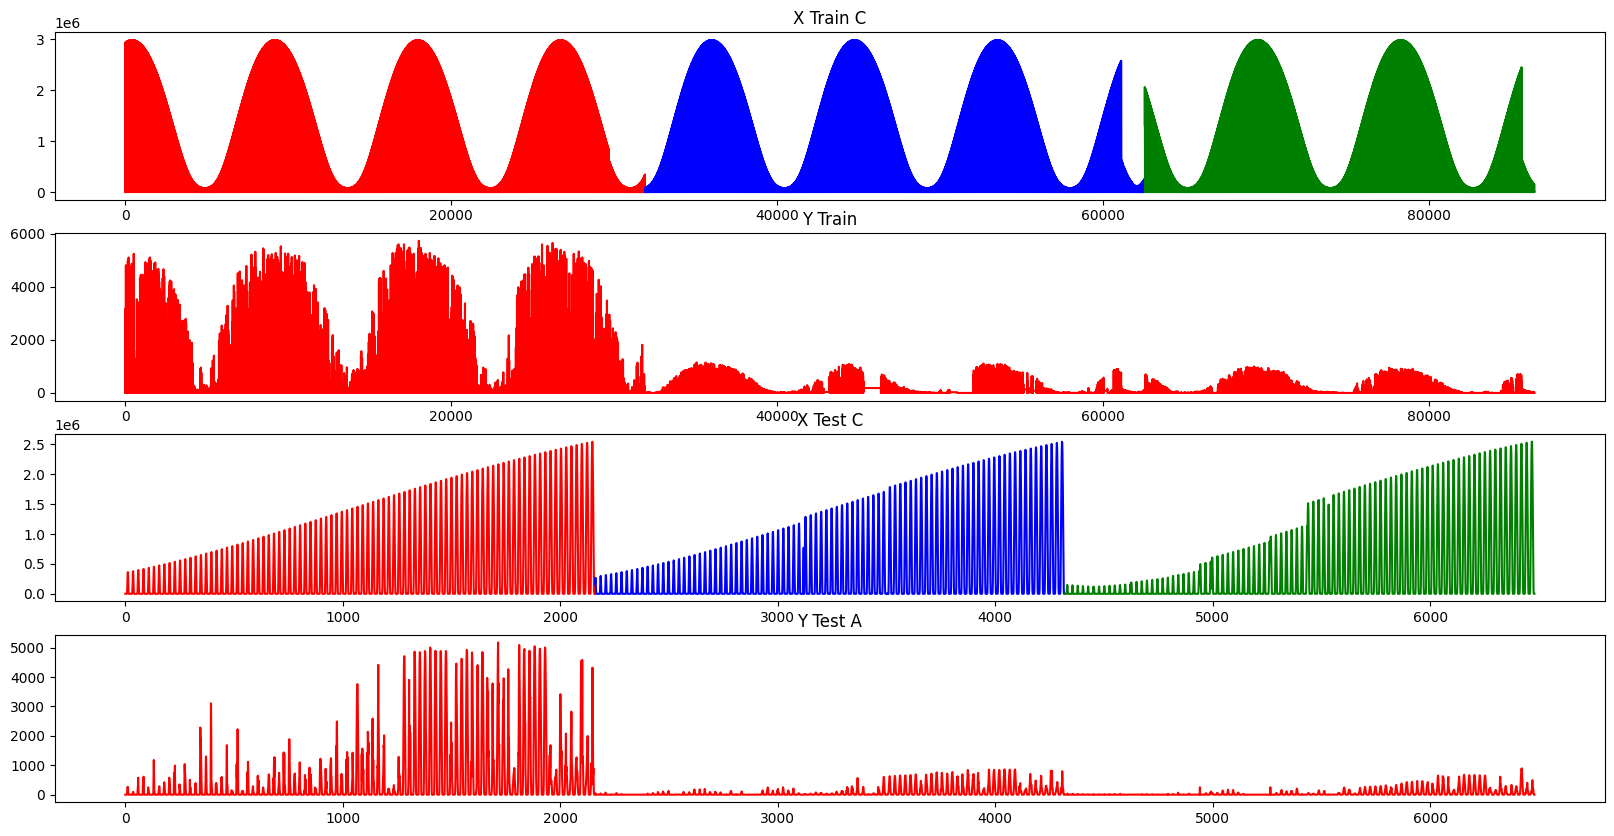

In [47]:
fig, axs = plt.subplots(4, 1, figsize=(20, 10), sharex=False)

feature_name = "clear_sky_energy_1h:J"
X_train.loc[X_train['location'] == 'a'][feature_name].plot(ax=axs[0], title='X Train A', color='red')
X_train.loc[X_train['location'] == 'b'][feature_name].plot(ax=axs[0], title='X Train B', color='blue')
X_train.loc[X_train['location'] == 'c'][feature_name].plot(ax=axs[0], title='X Train C', color='green')
y_train.plot(ax=axs[1], title='Y Train', color='red')

X_test.loc[X_test['location'] == 'a'][feature_name].plot(ax=axs[2], title='X Test A', color='red')
X_test.loc[X_test['location'] == 'b'][feature_name].plot(ax=axs[2], title='X Test B', color='blue')
X_test.loc[X_test['location'] == 'c'][feature_name].plot(ax=axs[2], title='X Test C', color='green')
if local_test:
    y_test.plot(ax=axs[3], title='Y Test A', color='red')

In [48]:

normalize = False
if normalize:
    scaler = preprocessing.MinMaxScaler()
    X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
    X_test[numeric_features] = scaler.fit_transform(X_test[numeric_features])

### Final steps

In [49]:
train_pool = cb.Pool(
    X_train,
    y_train,
    cat_features = made_features
)
if local_test:
    test_pool = cb.Pool(
        X_test,
        y_test,
        cat_features = made_features
    )
else:
    test_pool = cb.Pool(
        X_test,
        cat_features = made_features
    )



model = cb.CatBoostRegressor(
    iterations = 10000,
    depth = 9,
    learning_rate =0.01,
    loss_function ='MAE',
    cat_features = made_features
)


In [50]:
#train the model
model.fit(train_pool)
# make the prediction using the resulting model
preds = model.predict(test_pool)


0:	learn: 289.5018377	total: 124ms	remaining: 31m
1:	learn: 288.6652998	total: 215ms	remaining: 26m 48s
2:	learn: 287.4699078	total: 337ms	remaining: 28m 6s
3:	learn: 286.4520925	total: 445ms	remaining: 27m 46s
4:	learn: 285.5299697	total: 561ms	remaining: 28m 1s
5:	learn: 284.5521125	total: 670ms	remaining: 27m 55s
6:	learn: 283.6890627	total: 780ms	remaining: 27m 50s
7:	learn: 282.7745619	total: 884ms	remaining: 27m 35s
8:	learn: 281.9353138	total: 979ms	remaining: 27m 10s
9:	learn: 281.0429430	total: 1.04s	remaining: 26m 6s
10:	learn: 280.0643105	total: 1.11s	remaining: 25m 9s
11:	learn: 279.0554160	total: 1.19s	remaining: 24m 40s
12:	learn: 277.9105246	total: 1.26s	remaining: 24m 11s
13:	learn: 276.8717953	total: 1.33s	remaining: 23m 43s
14:	learn: 275.8143886	total: 1.4s	remaining: 23m 16s
15:	learn: 274.7569717	total: 1.47s	remaining: 22m 57s
16:	learn: 273.7436923	total: 1.56s	remaining: 22m 59s
17:	learn: 272.7766717	total: 1.63s	remaining: 22m 40s
18:	learn: 271.8155488	total:

In [54]:
if local_test:
    print(f'MAE: {mean_absolute_error(preds, y_test)}')
    print(f'MAE on ReLU of y_pred: {mean_absolute_error(ReLU(preds), y_test)}')
    print(f'MAE on abs(-) of y_pred: {mean_absolute_error(np.abs(preds), y_test)}')


MAE: 74.7822808360865
MAE on ReLU of y_pred: 74.48417110424623
MAE on abs(-) of y_pred: 74.62165314404197


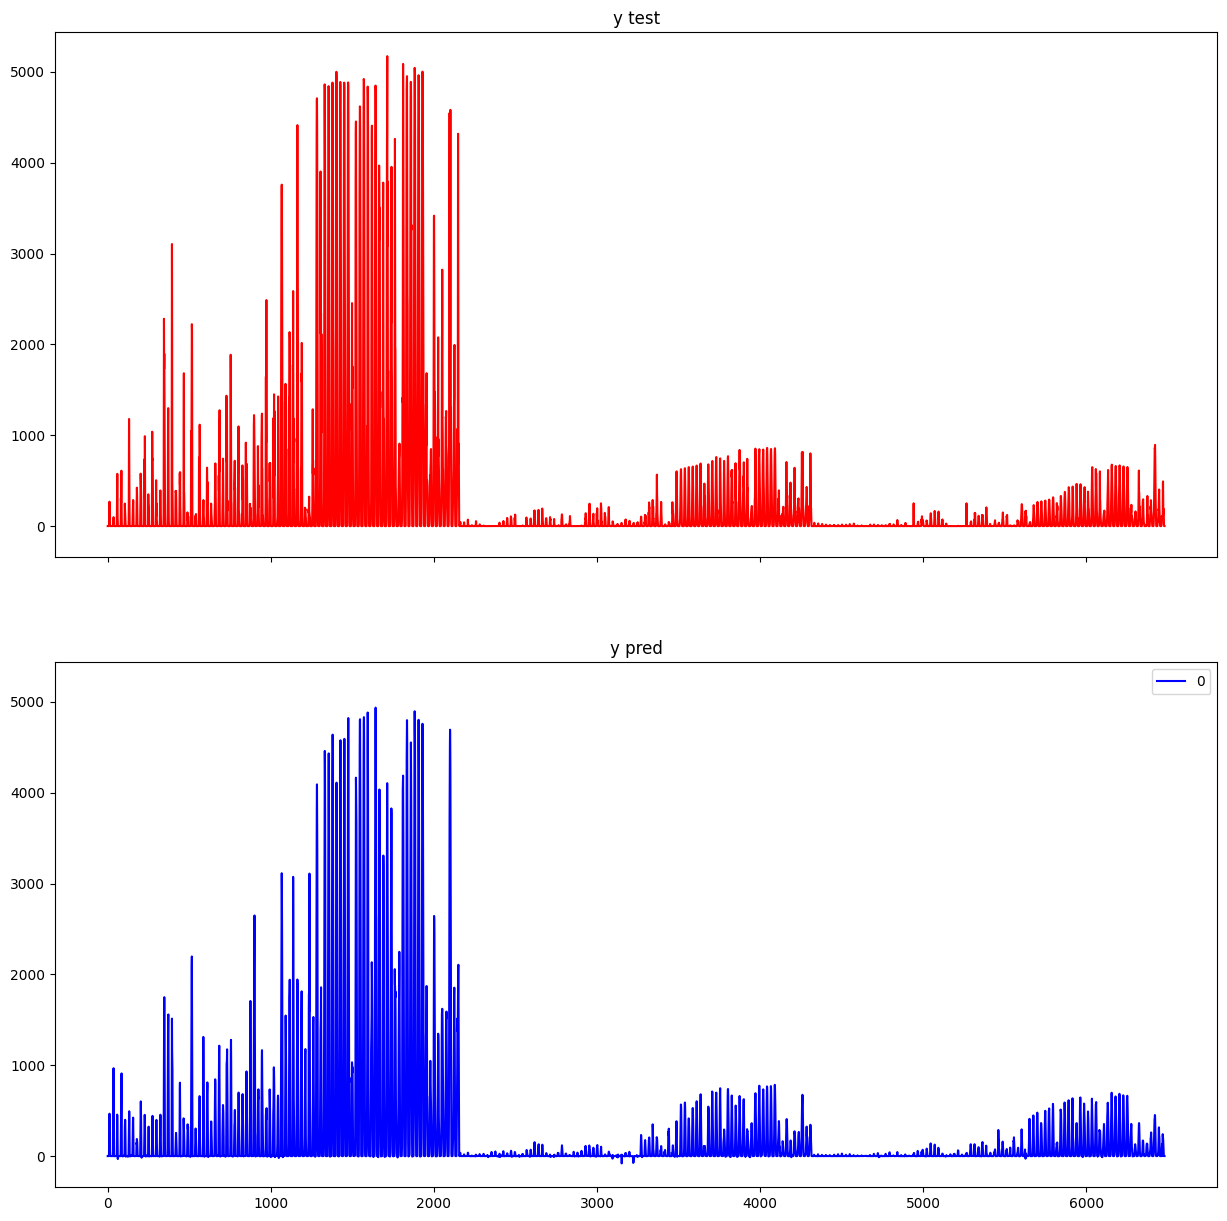

In [55]:
preds_df = pd.DataFrame(preds)

if local_test:
    fig, axs = plt.subplots(2,1,figsize = (15,15), sharex = True, sharey=True)
    y_test.plot(ax=axs[0], title='y test', color='red')
    preds_df.plot(ax=axs[1], title='y pred', color='blue')
else:
    preds_df.plot(title='y pred', color='blue')


In [53]:
# pred_to_delivery(ReLU(preds), 'catboost_fine_tune_4.csv')